In [1]:
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import seaborn as sns
import pickle
import pandas as pd
from scipy.ndimage import gaussian_filter1d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Computer Modern",
    "font.size" : 25,
    "font.weight" :900,
    "legend.fontsize" : 25,
    "xtick.labelsize" : 20,
    "ytick.labelsize" : 20,
    # 'axes.labelcolor': 'black',
    'axes.labelsize': 20,
    'axes.labelweight': 900,
    # "figure.dpi":300,
    # 'legend.fontsize': 20.0,
    # 'legend.labelcolor': 'black',
    'text.latex.preamble' :r'''
    \boldmath
    \usepackage{amsmath}
    \renewcommand{\rmdefault}{cmr}  % Use Computer Modern Roman
    '''
})


## BCMS data

In [20]:
bcms_net = pickle.load(open("/home/neha/bcms_network.pkl","rb"))

In [24]:
degree_flat = [bcms_net.degree(node) for node in bcms_net]
count = np.bincount(degree_flat)
k = np.arange(1, max(degree_flat) + 1)

FitParams(mu=np.float64(2.727197233939361), loc=np.float64(1.0))


Text(0.5, 1.0, '')

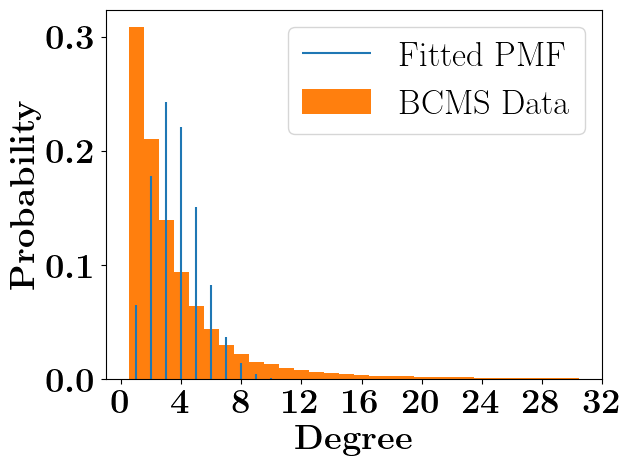

In [49]:
from scipy import stats
sub_ls = [i for i in degree_flat if i<=30]
dist = stats.poisson
bounds = [(0,len(sub_ls)),(0,2)]
res = stats.fit(dist, sub_ls,bounds)
print(res.params)
res.plot()
plt.legend(['Fitted PMF','BCMS Data'])
plt.xlabel(r'\textbf{Degree}')
plt.ylabel(r'\textbf{Probability}')
plt.title("")


## network plots

In [118]:

import networkx as nx

In [123]:
def get_network(network_type, N=100, p=0.5, alpha=3,mean_k=5):
    if network_type=='ER':
        p_ER = mean_k / (N - 1)
        G = nx.gnp_random_graph(N, p_ER)
    if network_type == 'SF':
        sequence = np.random.zipf(alpha, N)
        int_sequence = np.round(sequence).astype(int)
        if np.sum(int_sequence)%2!=0: int_sequence[0]+=1
        G = nx.configuration_model(int_sequence)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))
    if network_type == 'SW':
        G = nx.watts_strogatz_graph(N,mean_k,p)
    if network_type == 'PC':
        G = nx.powerlaw_cluster_graph(N,mean_k,p)
    if network_type == 'CG':
        G = nx.complete_graph(N)

    G.remove_nodes_from([i for i in G.nodes() if G.degree[i]==0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    return G

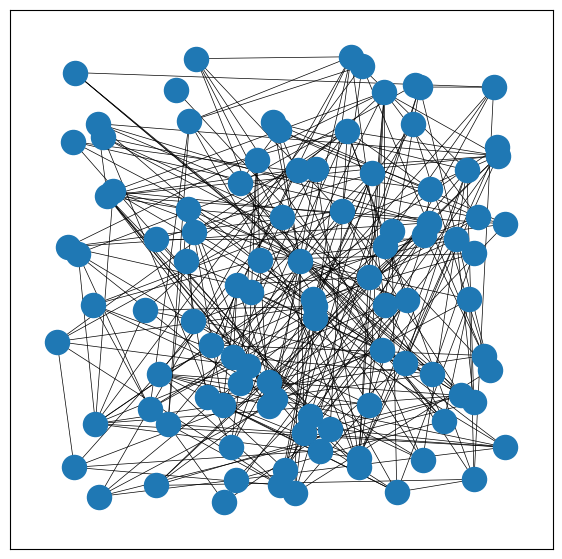

In [124]:
G = get_network(network_type='ER')
plt.figure(figsize=(7,7))
nx.draw_networkx(G,pos= nx.random_layout(G),with_labels=False,width=0.5)
plt.savefig("ER_net.png")


In [78]:
G = get_network(network_type='ER')
degree_flat = [G.degree(node) for node in G.nodes()]
count = np.bincount(degree_flat)/len(degree_flat)
k = np.arange(1, max(degree_flat) + 1)

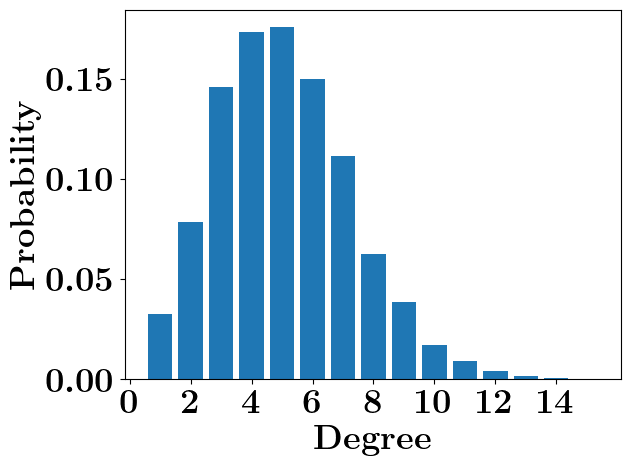

In [80]:
plt.bar(k,count[1:])
# plt.xlim((0,25))
plt.xticks(np.arange(0,15,2))
plt.xlabel(r'\textbf{Degree}')
plt.ylabel(r'\textbf{Probability}')
plt.savefig(f"ER_deg_OG.png", bbox_inches='tight')

In [82]:
for net in ['ER','SF','SW']:
    G = get_network(network_type=net)
    print(net,nx.average_clustering(G))

ER 0.0005213226703572639
SF 3.7063492063492065e-05
SW 0.07005626984127065


## Plotting degree distribution

In [4]:
directory = 'results_dup'
network = 'ER'

if network.find("ER")>=0 :
    deg_dict = {'OG':[],'RW':[],'MHRW':[]}
    for idx in range(1,4,1):
        tmp_deg_dict = pickle.load(open(f"/home/neha/{directory}/{network}_{idx}_deg_rm_dup.pkl","rb"))
        for key in deg_dict.keys():
            deg_dict[key].extend(tmp_deg_dict[key])
else:
    deg_dict = pickle.load(open(f"/home/neha/{directory}/{network}_deg_rm_dup.pkl","rb"))

for i,algo in enumerate(['OG','RW','MHRW']):
    print(f"{algo} starts")
    degree_flat = deg_dict[algo]
    count = np.bincount(degree_flat)/len(degree_flat)
    y_smooth = gaussian_filter1d(count[1:], sigma=2)
    max_count = np.max(count)
    k = np.arange(1, max(degree_flat) + 1)
    tmp_dict = {'k':k,'y':y_smooth,'count':count[1:]}
    df = pd.DataFrame(tmp_dict)
    
    if i==0:
        master_df = df.copy()
    else :
        df.columns = [f"{col}_{algo}" for col in df.columns]
        master_df = pd.merge(master_df,df, left_on ='k', right_on=f'k_{algo}',how='left')
    print(f"{algo} ends")

master_df['net_RW'] = (master_df['count_RW'])/master_df['count']
master_df['net_MHRW'] = ( master_df['count_MHRW'])/master_df['count']
master_df = master_df.dropna()

OG starts
OG ends
RW starts
RW ends
MHRW starts
MHRW ends


### plots

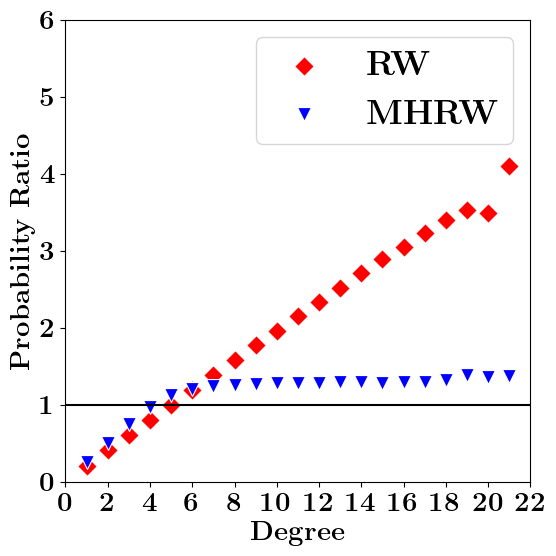

In [5]:
if network.find("SF")>=0:
    xll = 1000
    xul = 200
    yul = 50
else :
    xll = max(master_df['k'])
    xul = 2
    yul = 1

plt.figure(figsize=(6,6))

marker_map = {'RW':'D','MHRW':'v'}
color_map = {'RW':'red','MHRW':'blue'}
plot_df =  master_df[master_df['k']<=xll]

for algo in ['RW','MHRW']:

    sns.scatterplot(x=plot_df['k']
                    ,y=plot_df[f'net_{algo}']
                    ,label=r"$\textbf{"+algo+r"}$"
                    ,color=color_map[algo]
                    ,s=100
                    ,marker=marker_map[algo])
    
    if network.find("SF")>=0:
        plt.yticks(np.arange(0,250+yul,yul))
    else :
        plt.yticks(np.arange(0,max(plot_df['net_RW']+plot_df['net_MHRW'])+yul,yul))
    
    plt.xticks(np.arange(0,xll+xul,xul))

plt.axhline(y=1,color='black')
plt.legend()
plt.ylabel(r'\textbf{Probability Ratio}')
plt.xlabel(r'\textbf{Degree}')
plt.savefig(f'deg_dist_ratio_{network}.png', bbox_inches='tight')


### Hypothesis test

1. Degree
Numerical -> discrete -> 
2. Clustering Coefficient 
Numerical -> continuous -> not-normal distribution (Kolmorgorov-Smirnov Test) -> descriptive stats (IQR, range) -> Wilcoxon -> one-sample/ independent-samples

In [20]:
from scipy.stats import mannwhitneyu ## it is for continuous non-normal distribution
from scipy.stats import chisquare ## discrete variable
from scipy import stats

- H0 - there is no association between two samples or sample and underlying network 
- H1 - two samples are associated 
- Chisquare Test : p-values are >0.05, so we accept the null-hypothesis, mean there is no association


In [19]:
for algo1 in results_dict.keys():
    for algo2 in results_dict.keys():
        if algo1 != algo2:
            # U1, p = mannwhitneyu(results_dict[algo1]['count'], results_dict[algo2]['count'], method="asymptotic") ## two-sided
            # print(algo1,algo2, U1, p)
            U1,p = chisquare(results_dict[algo1]['count'], results_dict[algo2]['count'])
            print(algo1,algo2, U1, p)

net RW 0.28715007161179573 0.9999999999999991
net MHRW 0.14926774689592903 1.0
RW net 0.18443787093676461 1.0
RW MHRW 0.04453564587311436 1.0
MHRW net 0.07333443996260866 1.0
MHRW RW 0.03678493698609494 1.0


- H0 - population median of the samples is equal
- H1 - population median of the samples is not equal
- Kruskal-Wallis H-test : p-values are >0.05, so we accept the null-hypothesis


In [21]:
stats.kruskal(results_dict['net']['count'], results_dict['RW']['count'],results_dict['MHRW']['count'])

KruskalResult(statistic=np.float64(0.01388888888885731), pvalue=np.float64(0.9930796124903317))

Text(0, 0.5, '\\textbf{Probability}')

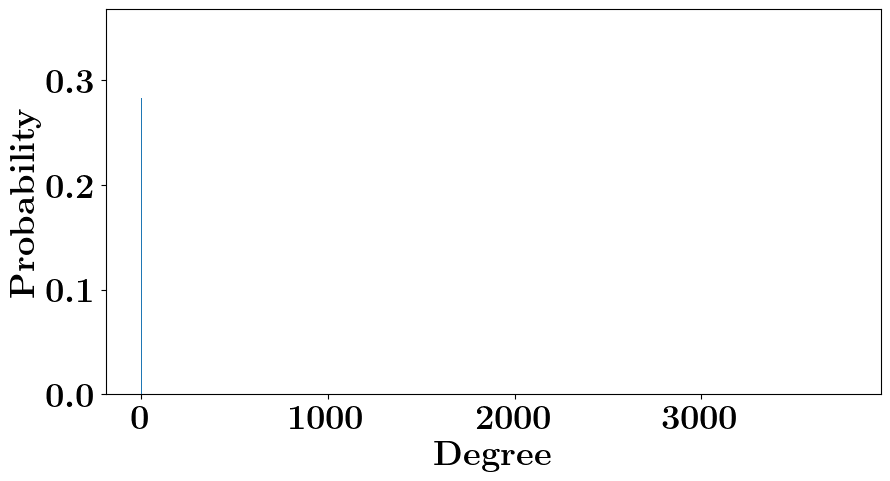

In [51]:
# plt.figure(figsize=(10,5))
# plt.bar(results_dict['net']['k'],results_dict['net']['y'])
# # plt.xticks(np.arange(0,20,2))
# plt.xlabel(r'\textbf{Degree}')
# plt.ylabel(r'\textbf{Probability}')
# # plt.savefig(f"{network}_deg_OG.png", bbox_inches='tight')

## Clustering Coeff

### Stacked plot

In [22]:
# for network in ['SF']:
    # if network == 'ER':
    #     avg_clust_dict = {'net':[],'RW':[],'MHRW':[]}
    #     global_clust_dict = {'net':[],'RW':[],'MHRW':[]}
    #     for network_idx in ['ER_1','ER_2','ER_3']:
    #     # network = 'ER_1'
    #         tmp_dict1  = pickle.load(open(f"/home/neha/results/{network_idx}_avg_clust_coeff.pkl","rb"))
    #         tmp_dict2  = pickle.load(open(f"/home/neha/results/{network_idx}_global_clust_coeff.pkl","rb"))
    #         for key in avg_clust_dict.keys():
    #             avg_clust_dict[key].extend(tmp_dict1[key])
    #             global_clust_dict[key].extend(tmp_dict2[key])
    #         # break
    # else :
network = 'SW'
avg_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_avg_clust_coeff.pkl","rb"))
global_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_global_clust_coeff.pkl","rb"))


In [23]:
dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    df['Value'] = df['Value']*100
    
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='Value', hue='Network', multiple='fill',stat='count')
    # plt.xticks(np.arange(0,max(df['Value']),0.04))
    if key=='avg':
        plt.xlabel(r'\textbf{Average Clustering Coefficient \%}')
    else :
        plt.xlabel(r'\textbf{Global Clustering Coefficient \%}')
    plt.ylabel(r'\textbf{Relative Frequency}')
    plt.legend([r'\textbf{OG}',r'\textbf{RW}',r'\textbf{MHRW}'],loc='upper right')
    # plt.savefig(f"{network}_{key}_clust.png")

- H0 - algo1 not <  algo2 
- H1 - algo1 < algo 2
- Conclusion : 
    - p<0.05, reject null hypothesis, OG < RW/MHRW
    - p< 0.05, reject null hypothesis, MHRW < RW

In [31]:
for algo1 in df['Network'].unique():
    for algo2 in df['Network'].unique():
        if algo1 != algo2:
            U1, p = mannwhitneyu(df[df['Network']==algo1]['Value'], df[df['Network']==algo2]['Value']
                                    , method="asymptotic",
                                    alternative ='less') 
            # print(algo1,algo2, U1, p)
            print(algo1,algo2, U1, p)

OG RW 8798885.0 0.0
OG MHRW 14582755.0 0.0
RW OG 91201115.0 1.0
RW MHRW 58782621.0 1.0
MHRW OG 85417245.0 1.0
MHRW RW 41217379.0 5.958675594520196e-103


### box plot

(0.05, 0.09)

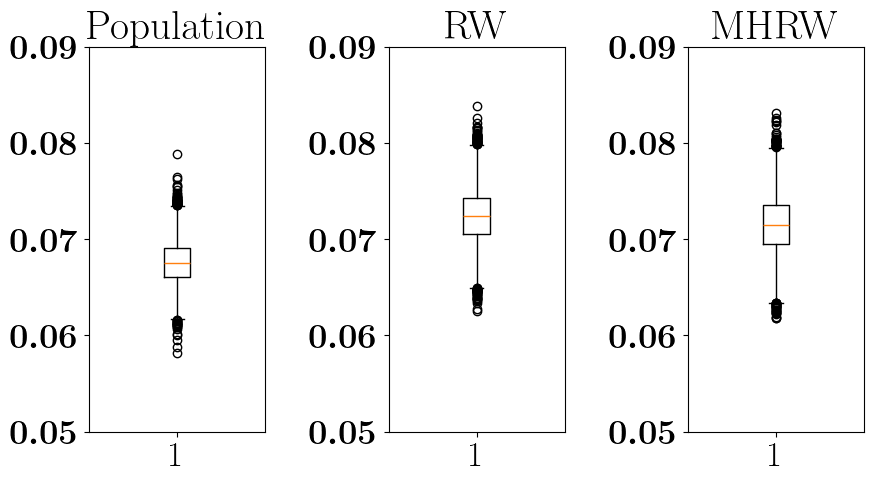

In [14]:
network = 'SW'
avg_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_avg_clust_coeff.pkl","rb"))
global_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_global_clust_coeff.pkl","rb"))

dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    break

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.7)
plt.subplot(131)
plt.boxplot(df[df['Network']=='OG']['Value'])
plt.ylim(0.05,0.09)
plt.title("Population")
plt.subplot(132)
plt.boxplot(df[df['Network']=='RW']['Value'])
plt.title("RW")
plt.ylim(0.05,0.09)
plt.subplot(133)
plt.boxplot(df[df['Network']=='MHRW']['Value'])
plt.title("MHRW")
plt.ylim(0.05,0.09)

Text(0.5, 1.0, 'MHRW')

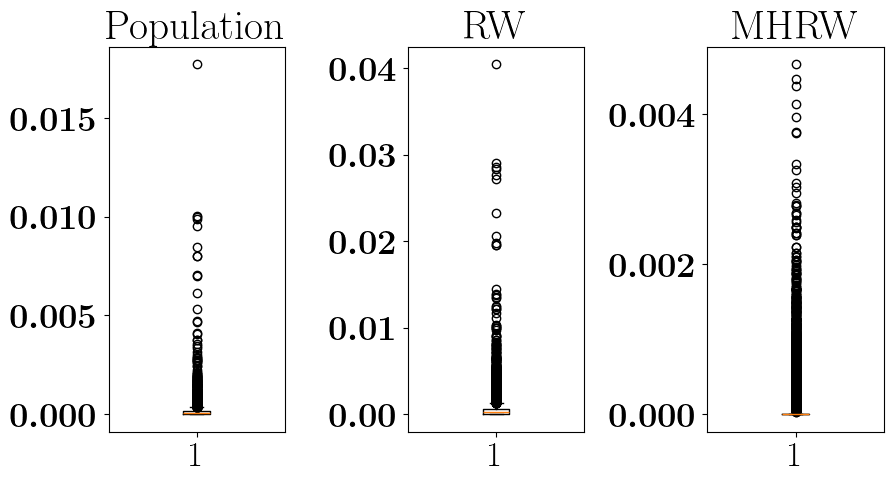

In [16]:
network = 'SF'
avg_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_avg_clust_coeff.pkl","rb"))
global_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_global_clust_coeff.pkl","rb"))

dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    break

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.7)
plt.subplot(131)
plt.boxplot(df[df['Network']=='OG']['Value'])
# plt.ylim(0.05,0.09)
plt.title("Population")
plt.subplot(132)
plt.boxplot(df[df['Network']=='RW']['Value'])
plt.title("RW")
# plt.ylim(0.05,0.09)
plt.subplot(133)
plt.boxplot(df[df['Network']=='MHRW']['Value'])
plt.title("MHRW")
# plt.ylim(0.05,0.09)

(0.0, 0.002)

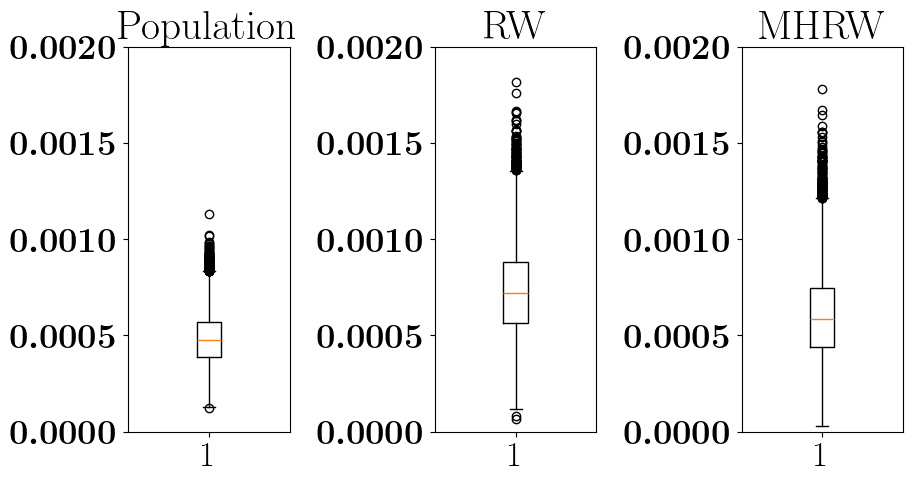

In [20]:
avg_clust_dict = {'net':[],'RW':[],'MHRW':[]}
global_clust_dict = {'net':[],'RW':[],'MHRW':[]}
for network_idx in ['ER_1','ER_2','ER_3']:
    tmp_dict1  = pickle.load(open(f"/home/neha/results/{network_idx}_avg_clust_coeff.pkl","rb"))
    tmp_dict2  = pickle.load(open(f"/home/neha/results/{network_idx}_global_clust_coeff.pkl","rb"))
    for key in avg_clust_dict.keys():
        avg_clust_dict[key].extend(tmp_dict1[key])
        global_clust_dict[key].extend(tmp_dict2[key])

dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    break

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.9)
plt.subplot(131)
plt.boxplot(df[df['Network']=='OG']['Value'])
plt.ylim(0,0.002)
plt.title("Population")
plt.subplot(132)
plt.boxplot(df[df['Network']=='RW']['Value'])
plt.title("RW")
plt.ylim(0,0.002)
plt.subplot(133)
plt.boxplot(df[df['Network']=='MHRW']['Value'])
plt.title("MHRW")
plt.ylim(0,0.002)

### hist plot

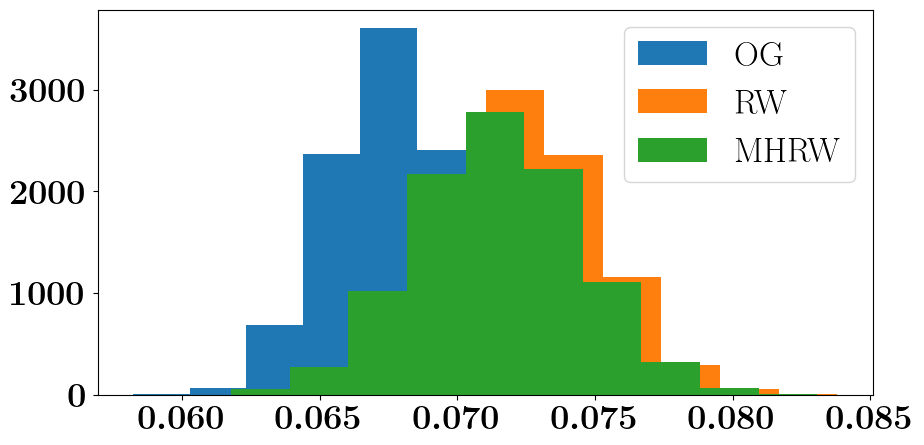

In [22]:
network = 'SW'
avg_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_avg_clust_coeff.pkl","rb"))
global_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_global_clust_coeff.pkl","rb"))

dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    break


plt.figure(figsize=(10,5))
for network_t in df['Network'].unique():
    plt.hist(df[df['Network']==network_t]['Value'],label=network_t)
plt.legend()



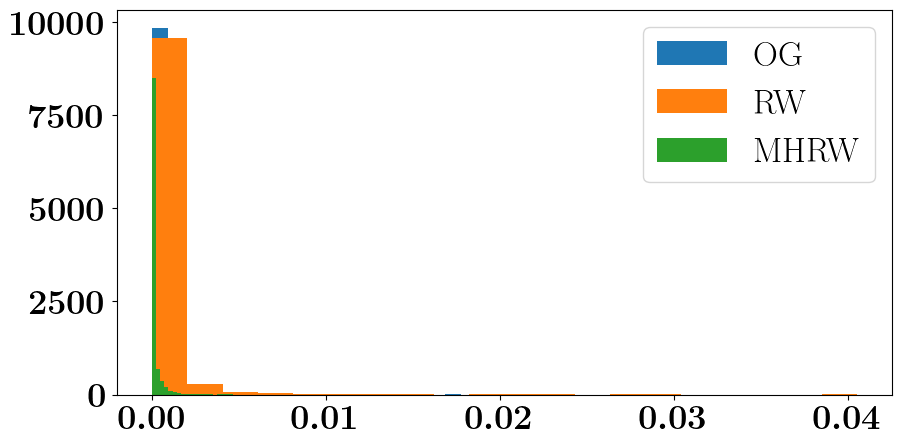

In [25]:
network = 'SF'
avg_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_avg_clust_coeff.pkl","rb"))
global_clust_dict = pickle.load(open(f"/home/neha/results/{network}_combined_global_clust_coeff.pkl","rb"))

dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    break


plt.figure(figsize=(10,5))
for network_t in df['Network'].unique():
    plt.hist(df[df['Network']==network_t]['Value'],bins=20,label=network_t)
plt.legend()



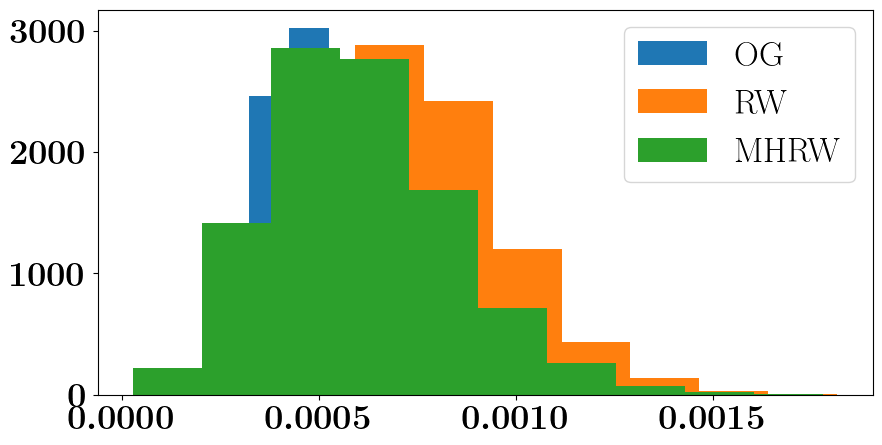

In [26]:
avg_clust_dict = {'net':[],'RW':[],'MHRW':[]}
global_clust_dict = {'net':[],'RW':[],'MHRW':[]}
for network_idx in ['ER_1','ER_2','ER_3']:
    tmp_dict1  = pickle.load(open(f"/home/neha/results/{network_idx}_avg_clust_coeff.pkl","rb"))
    tmp_dict2  = pickle.load(open(f"/home/neha/results/{network_idx}_global_clust_coeff.pkl","rb"))
    for key in avg_clust_dict.keys():
        avg_clust_dict[key].extend(tmp_dict1[key])
        global_clust_dict[key].extend(tmp_dict2[key])

dict_of_dict = {'avg':avg_clust_dict,'global':global_clust_dict}
for key,value in dict_of_dict.items():
    avg_dict= {}
    avg_dict['OG'] = value['net']
    for algo in ['RW','MHRW']:
        ls_avg = [np.mean(value[algo][i:i+100]) for i in range(0,len(value[algo]),100)]
        avg_dict[algo] = ls_avg

    df = pd.DataFrame([(key, value) for key, values in avg_dict.items() for value in values], columns=['Network', 'Value'])
    break

plt.figure(figsize=(10,5))
for network_t in df['Network'].unique():
    plt.hist(df[df['Network']==network_t]['Value'],label=network_t)
plt.legend()

## SIR results

In [2]:
directory = 'results'

for network in ['ER']:
    
    if network == 'ER':
        master_df = pd.DataFrame()
        for idx in range(1,4,1):
            for algo in ['OG','RW','MHRW']:
                df = pickle.load(open(f"/home/neha/{directory}/{network}/{network}_{idx}_{algo}_SIR_agg.pkl","rb"))
                # df['scaler'] = df['sample_size']
                df['scaler'] = 500
                df['node_idx'] = df['node_idx']/df['scaler']
                master_df = pd.concat([master_df,df],axis=0)
    else:
        master_df = pd.DataFrame()
        for algo in ['OG','RW','MHRW']:
            df = pickle.load(open(f"/home/neha/{directory}/{network}_combined_{algo}_SIR_agg.pkl","rb"))
            df['scaler'] = df['sample_size']
            df['node_idx'] = df['node_idx']/df['scaler']
            master_df = pd.concat([master_df,df],axis=0)

    plot_df = master_df.groupby(['beta','algo']).agg({'node_idx':['mean','std'],'second_inf':['mean','std'],'inf_time':['mean','std']}).reset_index()
    plot_df.columns = ['_'.join(col).strip() for col in plot_df.columns.values]

    custom_palette = {
        'OG': ['purple','o','-'], 
        'RW': ['red','v','--'], 
        'MHRW':['blue','s',':']
    }
    # for col in ['node_idx','second_inf','inf_time']:
    xlabeldict = {'node_idx': 'Proportion infected','second_inf':'Secondary infections','inf_time':'Infection time'}
    for col in ['node_idx','second_inf','inf_time']:
        if col == 'second_inf':
            plt.figure(figsize=(6,6))
            for algo in plot_df.algo_.unique():
                tmp_df = plot_df[plot_df['algo_']==algo]
                if algo=='OG': label = r'\textbf{'+'UN'+'}'
                else : label = r'\textbf{'+algo+'}'
                plt.plot(tmp_df['beta_'],tmp_df[f'{col}_mean']
                        ,color=custom_palette[algo][0]
                        ,linewidth=3,markersize=10
                        ,linestyle=custom_palette[algo][2]
                        ,label=label)
                plt.fill_between(tmp_df['beta_'],
                                np.clip(tmp_df[f'{col}_mean'] - tmp_df[f'{col}_std'], 0, None),
                                tmp_df[f'{col}_mean'] + tmp_df[f'{col}_std']
                                ,alpha = 0.3
                                ,color = custom_palette[algo][0]
                                )
                plt.xticks(np.arange(0,1.2,0.2))
            plt.legend()
            plt.xlabel(r'\textbf{$\beta$}')
            plt.ylabel(r'\textbf{'+xlabeldict[col]+'}')
            # plt.savefig(f"plots/right/{network}_{col}_SIR_ES.png", bbox_inches='tight')
            # break

        else :
            # Create a pivot table with aggregation
            pivot_df = pd.pivot_table(master_df, 
                                    values=col, 
                                    index='beta', 
                                    columns='algo', 
                                    aggfunc=['mean','std'],  # You can use 'mean', 'sum', 'max', etc.
                                    fill_value=0)   # Fill missing values with 0

            pivot_df = pivot_df.reset_index()
            pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
            for algo in ['RW','MHRW']:
                pivot_df[f'{algo}_ratio'] = pivot_df[f'mean_{algo}']/ pivot_df['mean_OG']
                pivot_df[f'{algo}_ratio_max'] = (pivot_df[f'mean_{algo}']+pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']+pivot_df['std_OG'])
                pivot_df[f'{algo}_ratio_min'] = (pivot_df[f'mean_{algo}']-pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']-pivot_df['std_OG'])

                pivot_df[f'{algo}_ratio'] = pivot_df[f'{algo}_ratio'].apply(lambda x: 0 if x<0 else x)
                pivot_df[f'{algo}_ratio_max']  = pivot_df[f'{algo}_ratio_max'].apply(lambda x: 0 if x<0 else x)
                pivot_df[f'{algo}_ratio_min'] = pivot_df[f'{algo}_ratio_min'].apply(lambda x: 0 if x<0 else x)

            plt.figure(figsize=(6,6))
            for algo in ['RW','MHRW']:
                plt.plot(pivot_df['beta_'],pivot_df[f'{algo}_ratio'],label=r'\textbf{'+algo+'}',linewidth=4,linestyle=custom_palette[algo][2],color=custom_palette[algo][0])
                plt.fill_between(pivot_df['beta_'],
                                pivot_df[f'{algo}_ratio_min'],
                                pivot_df[f'{algo}_ratio_max'],
                                alpha=0.3,
                                color=custom_palette[algo][0]
                                )
                plt.xticks(np.arange(0,1.2,0.2))
            plt.axhline(y=1,color='black',linestyle='-',linewidth=2)
            plt.xlabel(r'\textbf{$\beta$}')
            plt.ylabel(r'\textbf{'+xlabeldict[col]+' ratio}')
            plt.legend()
            # plt.savefig(f"plots/right/{network}_{col}_ratio_SIR_ES.png", bbox_inches='tight')
            # break
    # break



KeyError: 'sample_size'

## BCMS SIR results


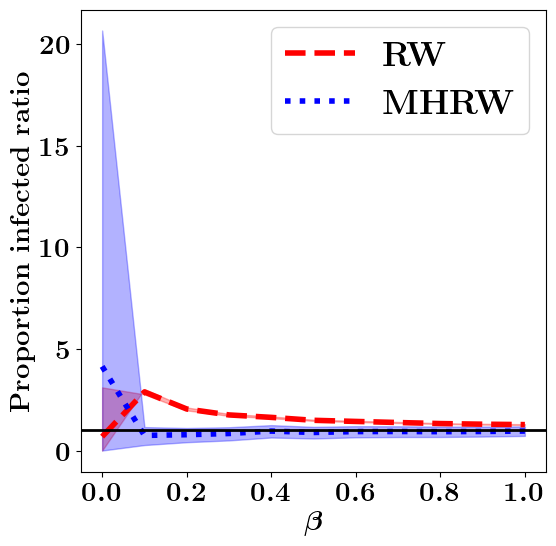

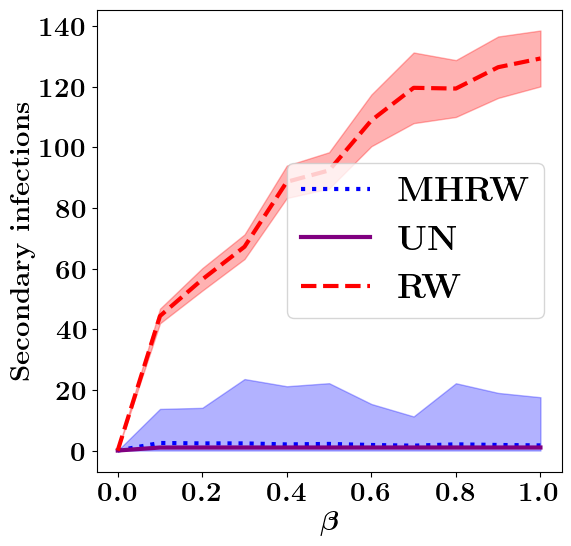

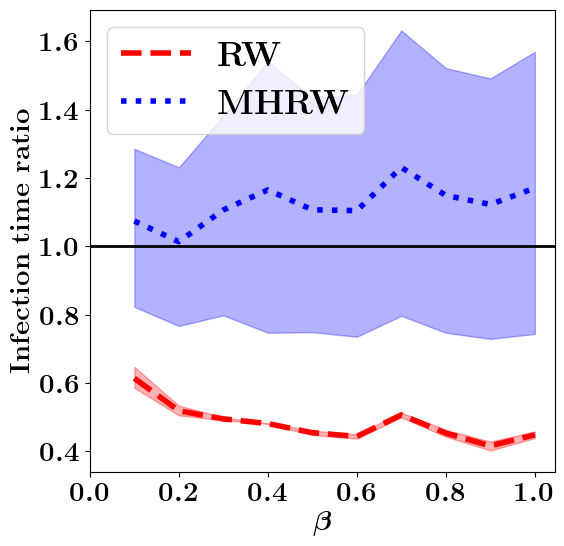

In [14]:
directory = 'results'
network = 'bcms_network'
suff = 'left'

master_df = pd.DataFrame()
for algo in ['OG','RW','MHRW']:
    df = pickle.load(open(f"/home/neha/{directory}/{network}_{algo}_SIR_agg_{suff}.pkl","rb"))
    if algo == 'OG' : df['scaler'] = 46512
    else : df['scaler'] = 2500
    # else: df['scaler'] = df['sample_size']
    df['node_idx'] = df['node_idx']/df['scaler']
    master_df = pd.concat([master_df,df],axis=0)

plot_df = master_df.groupby(['beta','algo']).agg({'node_idx':['mean','std'],'second_inf':['mean','std'],'inf_time':['mean','std']}).reset_index()
plot_df.columns = ['_'.join(col).strip() for col in plot_df.columns.values]

custom_palette = {
    'OG': ['purple','o','-'], 
    'RW': ['red','v','--'], 
    'MHRW':['blue','s',':']
}
xlabeldict = {'node_idx': 'Proportion infected','second_inf':'Secondary infections','inf_time':'Infection time'}

for col in ['node_idx','second_inf','inf_time']:
    if col == 'second_inf':
        plt.figure(figsize=(6,6))
        for algo in plot_df.algo_.unique():
            tmp_df = plot_df[plot_df['algo_']==algo]
            if algo=='OG': label = r'\textbf{'+'UN'+'}'
            else : label = r'\textbf{'+algo+'}'
            plt.plot(tmp_df['beta_'],tmp_df[f'{col}_mean']
                    ,color=custom_palette[algo][0]
                    ,linewidth=3,markersize=10
                    ,linestyle=custom_palette[algo][2]
                    ,label=label)
            plt.fill_between(tmp_df['beta_'],
                            np.clip(tmp_df[f'{col}_mean'] - tmp_df[f'{col}_std'], 0, None),
                            tmp_df[f'{col}_mean'] + tmp_df[f'{col}_std']
                            ,alpha = 0.3
                            ,color = custom_palette[algo][0]
                            )
            plt.xticks(np.arange(0,1.2,0.2))
        plt.legend()
        plt.xlabel(r'\textbf{$\beta$}')
        plt.ylabel(r'\textbf{'+xlabeldict[col]+'}')
        plt.savefig(f"{network}_{col}_SIR_ES_{suff}.png", bbox_inches='tight')
        # break

    else :
        # Create a pivot table with aggregation
        pivot_df = pd.pivot_table(master_df, 
                                values=col, 
                                index='beta', 
                                columns='algo', 
                                aggfunc=['mean','std'],  # You can use 'mean', 'sum', 'max', etc.
                                fill_value=0)   # Fill missing values with 0

        pivot_df = pivot_df.reset_index()
        pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
        for algo in ['RW','MHRW']:
            pivot_df[f'{algo}_ratio'] = pivot_df[f'mean_{algo}']/ pivot_df['mean_OG']
            pivot_df[f'{algo}_ratio_max'] = (pivot_df[f'mean_{algo}']+pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']+pivot_df['std_OG'])
            pivot_df[f'{algo}_ratio_min'] = (pivot_df[f'mean_{algo}']-pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']-pivot_df['std_OG'])

            pivot_df[f'{algo}_ratio'] = pivot_df[f'{algo}_ratio'].apply(lambda x: 0 if x<0 else x)
            pivot_df[f'{algo}_ratio_max']  = pivot_df[f'{algo}_ratio_max'].apply(lambda x: 0 if x<0 else x)
            pivot_df[f'{algo}_ratio_min'] = pivot_df[f'{algo}_ratio_min'].apply(lambda x: 0 if x<0 else x)

        plt.figure(figsize=(6,6))
        for algo in ['RW','MHRW']:
            plt.plot(pivot_df['beta_'],pivot_df[f'{algo}_ratio'],label=r'\textbf{'+algo+'}',linewidth=4,linestyle=custom_palette[algo][2],color=custom_palette[algo][0])
            plt.fill_between(pivot_df['beta_'],
                            pivot_df[f'{algo}_ratio_min'],
                            pivot_df[f'{algo}_ratio_max'],
                            alpha=0.3,
                            color=custom_palette[algo][0]
                            )
            plt.xticks(np.arange(0,1.2,0.2))
        plt.axhline(y=1,color='black',linestyle='-',linewidth=2)
        plt.xlabel(r'\textbf{$\beta$}')
        plt.ylabel(r'\textbf{'+xlabeldict[col]+' ratio}')
        plt.legend()
        plt.savefig(f"{network}_{col}_ratio_SIR_ES_{suff}.png", bbox_inches='tight')
        # break
# break



In [9]:
network_file = pickle.load(open("/home/neha/bcms_network.pkl","rb"))

In [11]:
len(network_file.nodes())

46512